# Assignment 4 - Multiclass Classifier Neural Network

In [17]:
import pandas as pd

## Step 1: Load the Data

In [2]:
df = pd.read_csv('a4-data/train.csv')
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Target
0,3289,22,19,240,93,1708,205,196,122,2598,...,0,1,0,0,0,0,0,0,0,1
1,2963,21,18,134,27,1243,206,200,127,1140,...,0,0,0,0,0,0,0,0,0,1
2,3037,185,9,127,10,6462,222,246,158,3037,...,0,0,0,0,0,0,0,0,0,2
3,3113,203,13,190,22,2125,213,251,171,730,...,1,0,0,0,0,0,0,0,0,2
4,3128,346,9,120,36,552,203,226,161,924,...,0,0,0,0,0,0,0,0,0,1


we need to check for any null or missing values and deal with them accordinly, here we have none

In [3]:
df.isnull().sum().sum()

0

## Step 2: Split the Data into Features (X) and Target (Y)

Here we split the training data into X and y variables where X containsa feature matrix and y contains a target vector, this is done so the model has a target value to compare to its predictions, this enables us to calculate the loss which utimately allows the model to learn.

In [4]:
# split dataset into features and target
X = df.drop('Target', axis=1)
y = df['Target']
X.shape, y.shape

((464809, 54), (464809,))

Now that we have our target and features separated, we need to normalize the feature matrix which will help the model converge to a minima faster by leveling out the gradient. The reason for not normalizing the target vector is because it contains categorical data which should not be normalized.

### Normalize the features

When no normalization is done the models accuracy is poor with a value less than 60%, but when all features arn normalized the models preformance dramitacally increases to over 90% 

We can take this one step further by only normalizing the non-binary features which improves the models performance even more, even when the model has a significantly higher accuracy of 93.6%, only normalizing the non-binary features gives us a 1% increase with a 94.6%

Here we get only the non-binary columns and normalize them using z-score normalization

In [5]:
binary_columns = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]

non_binary_columns = [col for col in X.columns if col not in binary_columns]

# Normalize non-binary columns
X[non_binary_columns] = (X[non_binary_columns] - X[non_binary_columns].mean()) / X[non_binary_columns].std()
X.head()


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54
0,1.177859,-1.194007,0.654794,-0.137989,0.800190,-0.411853,-0.267398,-1.381833,-0.536633,0.465718,...,0,0,1,0,0,0,0,0,0,0
1,0.014050,-1.202943,0.521222,-0.636898,-0.332414,-0.710007,-0.230025,-1.179489,-0.405884,-0.634309,...,0,0,0,0,0,0,0,0,0,0
2,0.278228,0.262598,-0.680919,-0.669844,-0.624145,2.636370,0.367936,1.147456,0.404757,0.796933,...,0,0,0,0,0,0,0,0,0,0
3,0.549545,0.423450,-0.146634,-0.373323,-0.418217,-0.144476,0.031583,1.400385,0.744704,-0.943645,...,0,1,0,0,0,0,0,0,0,0
4,0.603095,1.701330,-0.680919,-0.702791,-0.177968,-1.153070,-0.342143,0.135741,0.483206,-0.797276,...,0,0,0,0,0,0,0,0,0,0


## Step 3: Data Splitting

We need to split our data into training and test datasets so that we can evaulate and validate our models performance, if we tested on the entire dataset, we would not be testing the model on unseen data which would not be a valid test of its performance.

In [6]:
from sklearn.model_selection import train_test_split

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((325366, 54), (139443, 54), (325366,), (139443,))

## Step 4: Build the Neural Network Model

Here we build the model. In order to have optimal parameters, I decided to use the Hyperband algorithm to tune my parameters using the kerastuner library. I first started with a small depth and width, letting the algorithm find the optimal learning rate. The smaller models performed well, but by having a larger neural network lead to better models.

The best model from the Hyperband process has the following parameters:
- 54 node input layer, for the 54 features in X
- 120 node hidden layer, relu activation
- 112 node hidder layer, relu activation
- 104 node hidden layer, relu activation
- 80 node hidden layer, relu activation
- 7 node output layer, sofmax actiavtion
- learned rate of 0.00085410586

I tested using few layers but utimately ended up with 4 hidden layers which seemed to give good results for the model

Relu was used as the activation fucntion for hidden layers because it introduces non-linearity into the model which allows the model to learn complex patterns and relationships which is what we are trying to achieve with are classifier.

Softmax was used for the output layers activation function as it converts the raw output from a neural network into probabilites which we can then select the class with the highest probabilty, this is perfect for our classifiers output layer.

Since the number of nodes in the output layer of the model needs to match the range for the taget, we use the targets unique value count plus 1 as the output layers shape

Here we set up the model with our found widths for each layer from the hyperparameter tuning

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(units=120, activation='relu'),
    Dense(units=112, activation='relu'),
    Dense(units=104, activation='relu'),
    Dense(units=80, activation='relu'),
    Dense(units=(y_train.nunique()+1) , activation='softmax')
])

/Users/bradymitchelmore/Library/Mobile Documents/com~apple~CloudDocs/MUN/Year 3/Term 7/COMP 3401/Assignments/comp3401/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Step 5: Train the Model

Here we train the model using the learning rate from our hyperparameter tuning and 100 epochs
- I choose the Adam optimizer due to its adaptive learning rates and efficiency which help the model converge faster. 
- The loss fucntion used was sparse_categorical_crossentropy, which is a function that is good when dealing with multiclass claissification where each sample belongs to one of many classes and the labels are numeric, these are 2 properties of our target vector which deems this loss function suitable. 

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.00085410586

optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 9s 828us/step - accuracy: 0.7519 - loss: 0.5861 - val_accuracy: 0.8319 - val_loss: 0.4034
Epoch 2/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 8s 761us/step - accuracy: 0.8403 - loss: 0.3805 - val_accuracy: 0.8606 - val_loss: 0.3378
Epoch 3/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 7s 702us/step - accuracy: 0.8671 - loss: 0.3204 - val_accuracy: 0.8728 - val_loss: 0.3068
Epoch 4/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 8s 798us/step - accuracy: 0.8812 - loss: 0.2870 - val_accuracy: 0.8860 - val_loss: 0.2772
Epoch 5/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 7s 733us/step - accuracy: 0.8916 - loss: 0.2620 - val_accuracy: 0.8945 - val_loss: 0.2582
Epoch 6/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 7s 714us/step - accuracy: 0.8991 - loss: 0.2450 - val_accuracy: 0.8917 - val_loss: 0.2592
Epoch 7/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 7s 694us/step - accuracy: 0.9059 - loss: 0.2303 - val_accuracy: 0.9028 - val_loss: 0.2371
Epoch 8/100
10168/10168 ━━━━━━━━━━━━━━━━━━━━ 7s 720us/s

## Step 6: Model Evaluation

Evaluating the model on the test set allows us to assess its performance on unseen data, giving us an indication of its generalization ability. Accuracy is used as a metric to quantify the percentage of correctly predicted instances, while the loss metric gives us an indication of how close our predictions are.

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

4358/4358 ━━━━━━━━━━━━━━━━━━━━ 2s 338us/step - accuracy: 0.9436 - loss: 0.1769
Loss: 0.17416204512119293, Accuracy: 0.9443858861923218


Here we can see our model gives us a 94.36% accuracy on the test set with a loss of just 0.1705

When training we used X_test and y_test as a validation set which gave us the val_accuaracy and val_loss which measure the accuracy and loss in terms of the test set. We can plot the validation vs the training accuracy and loss to visualize how the model fits to its training data better than unseen data

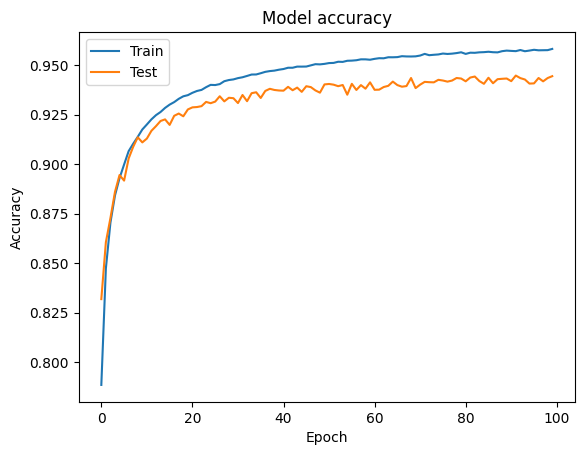

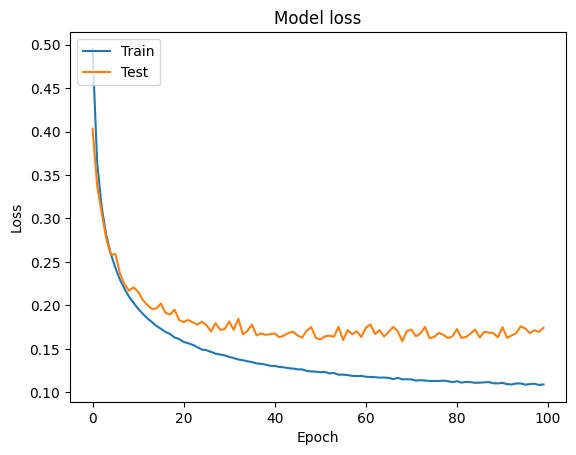

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In both graphs we see that the validation results arent quite as good which is expected as it is unseen data

## Step 7: Make Predictions

Making predictions involves feeding new data into the trained model and using the softmax probabilities to determine the most likely class for each instance. This process demonstrates the model's practical utility in classifying new, unseen data.

In [11]:
# load the test set
test_set = pd.read_csv('a4-data/test.csv')
test_set.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54
0,3351,206,27,726,124,3813,192,252,180,2271,...,0,0,0,0,0,0,0,1,0,0
1,2732,129,7,212,1,1082,231,236,137,912,...,0,0,0,0,0,0,0,0,0,0
2,2572,24,9,201,25,957,216,222,142,2191,...,0,0,0,0,0,0,0,0,0,0
3,2824,69,13,417,39,3223,233,214,110,6478,...,0,0,0,0,0,0,0,0,0,0
4,2529,84,5,120,9,1092,227,231,139,4983,...,0,0,0,0,0,0,0,0,0,0


We need to only scale binary columns like we did in the training data in order to get accurate predictions

In [12]:
binary_columns = [col for col in test_set.columns if test_set[col].dropna().isin([0, 1]).all()]

non_binary_columns = [col for col in test_set.columns if col not in binary_columns]

# Normalize non-binary columns
test_set[non_binary_columns] = (test_set[non_binary_columns] - test_set[non_binary_columns].mean()) / test_set[non_binary_columns].std()
test_set.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54
0,1.397080,0.448163,1.717586,2.142548,1.325494,0.939452,-0.749856,1.450328,0.974944,0.221676,...,0,0,0,0,0,0,0,1,0,0
1,-0.817890,-0.239629,-0.950993,-0.271829,-0.781223,-0.813558,0.704324,0.641019,-0.144637,-0.808430,...,0,0,0,0,0,0,0,0,0,0
2,-1.390419,-1.177526,-0.684135,-0.323499,-0.370156,-0.893795,0.145024,-0.067126,-0.014453,0.161037,...,0,0,0,0,0,0,0,0,0,0
3,-0.488686,-0.775570,-0.150419,0.691103,-0.130367,0.560735,0.778898,-0.471781,-0.847629,3.410530,...,0,0,0,0,0,0,0,0,0,0
4,-1.544286,-0.641585,-1.217851,-0.703975,-0.644200,-0.807139,0.555178,0.388110,-0.092563,2.277338,...,0,0,0,0,0,0,0,0,0,0


Now we use `model.predit()` to get a matrix with 7 columns and each row representing a probability distribution of the classes, we then get the highest probabilties index which is our prediction

In [13]:
import numpy as np

# make predictions and convert them to classes
predictions = model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 1s 293us/step


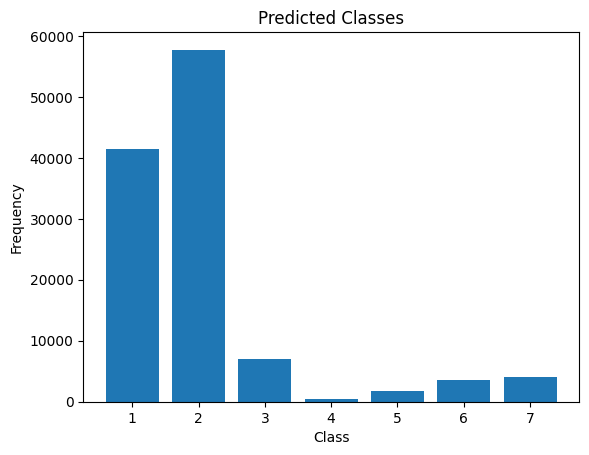

In [14]:
import matplotlib.pyplot as plt

# plot the predicted classes
plt.hist(predicted_classes, bins=range(1, 9), rwidth=0.8, align='left')
plt.title('Predicted Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Here we can see the the a large majority of predictions were either 1 or 2, this is a useful insight

## Step 8: Generate Submission File

In [15]:
# save the predictions to a CSV file
submission = pd.DataFrame({'Target': predicted_classes})
submission.to_csv('submission.csv')